### Imports

In [25]:
from data_functions import *
import copy
import os
import logging
import traceback

# sys.path.insert(1, "H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM")

import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from plot_lstm_results import plot_lstm_results
from network_models import LSTM
from train_test import train, test
from S2LDataset import S2LDataset
from print_error_report import print_error_report
from objective_functions import objective_function

# On the line below, specifiy after "from" which file the user inputs are coming from.
from input_template import (
    UserInputArgs,
    PlottingArgs,
    DataInfoArgs,
    SaveDataArgs,
    DerivedArgs,
)
from load_and_standardize import load_and_standardize
from reshape_for_time_resolution import reshape_for_time_resolution, reshape_full_series
from save_lstm import save_lstm_info, load_lstm_info
from save_lstm_results import save_lstm_results, save_lstm_test_results
from unstandardize_all_data import unstandardize_all_data

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt

### Description
Conduct TL on Unimodal network and compare to a Bimodaly trained network, both with uniform disperstion of sampling for TL/Bimodal
 - Unimodal NW = MED LSTM_Expanded
 - Unimodal training domain expanded to cover the entire area of interest
 - Area of interest:
    - Spd: 6 - 16 knts
    - Hdg: 0 - 360
 

### SETUP

In [2]:
print("Cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # to avoid some rare errors.

# Check if using CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set parameters
args = UserInputArgs()
plot_args = PlottingArgs()
data_info_args = DataInfoArgs()
save_data_args = SaveDataArgs()

# args.training_mode = False

# Load original LSTM
# args.model_load_filename = 'MED2_30'
# network, std_factors = load_lstm_info(args)
# network.to(device)

Cuda available: True


### Create and Train new Expanded MED LSTM
Only needs to be done once.  Replicates the main.py.  2 layers, 30 nodes. See main.py 

### Bimodal Network Network

Create and test bimodal network on N uniformly selected realiztions.  Return training files for future use with TL network

In [32]:
experiment = 'aavs'

# parse out the v1 and v2 variables
v1 = experiment.partition('v')[0]
v2 = experiment.partition('v')[2]
# set the experiment path for file collection
exp_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\{experiment}'
files = [f for f in os.listdir(exp_PATH + '\\LAMP_files') if f.endswith('1.mot')]

# Dictionary mapping v1 and v2 sample intervals to their respective experiements
# first list is v1, 2nd list is v2
index_dict = {'aavs': [30, 120, 210, 300], }

v1_range = set() # construct as set to avoid duplicates
v2_range = set()

# parse out all the combos of v1 and v2
for f in files:
    t1 = f.partition(v1)[2].partition('_')[0]
    if v2 == 's':
        t2 = f.partition(v2)[2].partition('-')[0]
    else:
        t2 = f.partition(v2)[2].partition('_')[0]

    v1_range.add(float(t1)) # add to set as a float
    v2_range.add(float(t2))

v1_range = sorted(v1_range) # convert back to list, sorted
v2_range = sorted(v2_range)


[0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0, 150.0, 165.0, 180.0, 195.0, 210.0, 225.0, 240.0, 255.0, 270.0, 285.0, 300.0, 315.0, 330.0, 345.0]
[157.89313712 136.50950816  92.51298959 205.02256029]
[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0]
[15.36934937  9.50819777]


In [34]:
360 / 4


90.0

In [3]:
def create_and_train_LSTM(experiment='', N=5):
    '''Create, train, and save a new LSTM on bimodal test sets.  Train on N randomly selected records for each bucket.'''

    # ID Experiment for tracking
    print("EXPERIMENT: ", experiment)

    # Setup GPU Support
    print("Cuda available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # to avoid some rare errors.

    # Check if using CPU or GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set parameters
    args = UserInputArgs()
    plot_args = PlottingArgs()
    data_info_args = DataInfoArgs()
    save_data_args = SaveDataArgs()

    # Update the args to 5 layers of 50 nodes
    args.num_layers = 5
    args.hidden_size = 50

    # Create list of eligible files to train on
    # exp_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\{experiment}'
    exp_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\{experiment}'
    files = [f for f in os.listdir(exp_PATH + '\\LAMP_files') if f.endswith('1.mot')]

    # randomly select N num_files to train on
    train_files = np.random.choice(files, size=N, replace = False)
    val_files = [f.replace('1.mot','2.mot') for f in train_files]

    # Shorten val_files to 20% of train_files, randomly selected
    val_files = np.random.choice(val_files, size=int(.2*len(val_files)), replace = False)

    # establish the lamp and sc training file paths
    data_info_args.train_lamp = [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in train_files]
    data_info_args.train_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in train_files]

    # establish the lamp and sc validation file paths
    data_info_args.val_lamp= [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in val_files]
    data_info_args.val_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in val_files]

    # Setup Derived Args
    derived_args = DerivedArgs(args, data_info_args)

    # Read in and standardize the training and validation data
    train_input, train_target, std_factors, train_sc = load_and_standardize(data_info_args.train_sc, data_info_args.train_lamp, args, std_factors=[])
    val_input, val_target, val_sc = load_and_standardize(data_info_args.val_sc, data_info_args.val_lamp, args, std_factors)

    print('Std_factors: ', std_factors)

    # Create the LSTM
    network = LSTM(args.input_size,args.hidden_size,args.num_layers,args.output_size,args.bi_directional,args.dropout,).to(device)

    # Update the save path
    args.model_save_filename = exp_PATH + f'\\{experiment}_BiMod{args.num_layers}_{args.hidden_size}_{N}_LSTM'

    # Reshape the data to take into account the time resolution
    train_input, train_target = reshape_for_time_resolution(train_input, train_target, args)
    val_input, val_target = reshape_for_time_resolution(val_input, val_target, args)

    # Create Dataset objects for each of our train/val/test sets
    train_dataset = S2LDataset(train_input, train_target)
    val_dataset = S2LDataset(val_input, val_target)

    # Create a PyTorch dataloader for each train/val set. Test set isn't needed until later
    train_loader = DataLoader(train_dataset, batch_size=derived_args.train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=derived_args.val_batch_size)

    # Display realization and batch numbers
    print("No of train realizations: ", derived_args.num_train_realizations)
    print("No of val realizations: ", derived_args.num_val_realizations)
    print("No of test realizations: ", derived_args.num_test_realizations)
    print("No of realizations: ", derived_args.num_realizations)
    print("Train batch size: ", derived_args.train_batch_size)
    realization_length = train_input.shape[1] * args.time_res

    # initialize our optimizer. We'll use Adam
    optimizer = torch.optim.Adam(network.parameters(), lr=args.lr)

    # Begin Training
    best_val_loss = float("inf")
    best_loss_counter = 0
    print("\n Beginning Training")
    start_time = time.time()
    for epoch in range(1, args.epochs + 1):
        train_loss = train(network, device, train_loader, optimizer, args.train_fun_hyp)
        val_loss = test(network, device, val_loader, args.val_fun_hyp)
        if val_loss < 0.95 * best_val_loss:
            best_val_loss = val_loss
            best_loss_counter = 0
            torch.save(network.state_dict(), "recently_trained_model.pt")
        else:
            best_loss_counter += 1
        if best_loss_counter > 30:
            break
        print("Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tCounter: {:02d}".format(epoch, train_loss, val_loss, best_loss_counter))
    print("Training Done\n")
    end_time = time.time()
    trainTime = end_time - start_time
    print("Training Time: ", trainTime)

    # restoring the best found network based on validation data
    network.load_state_dict(torch.load("recently_trained_model.pt"))

    # Save the LSTM
    save_lstm_info(network.state_dict(), args, data_info_args, std_factors)

    # Return the Training time
    return trainTime, train_files
    print('\n\n')


In [4]:
PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\'
ignore = ['Cases_files', '.ipynb_checkpoints','SecAngleOnly_test','__pycache__']
t = []
training_files = {}
exp_list = []
for exp in os.listdir(PATH):
    if os.path.isdir(PATH + exp) and exp not in ignore:
        try:
            train_time, training_files[exp] = create_and_train_LSTM(exp,N=5)
            t.append(train_time)
            exp_list.append(exp)
        except Exception as e:
            logging.error(traceback.format_exc())
            print('ERROR in ', exp)
            print('\n\n\n\n')
            continue
for key, value in training_files.items():
    print(key +': ', value)

EXPERIMENT:  aavs
Cuda available: True
full series simple (input) shape  (5, 17990, 4)
full series lamp (target) shape  (5, 17990, 3)
full series simple (input) shape  (1, 17990, 4)
full series lamp (target) shape  (1, 17990, 3)
Std_factors:  [2.0840608878544455, 1.790892439427494, 0.09204669762775652, 5.082366087545143, -0.051768439558689934, 1.441735591744332, -0.0023715295256097804, 2.0251789876420125, 1.8796101763133253, 1.8502283129620063, 0.015259587856544087, 6.845194086224119, 0.029330592169131628, 2.1321712734126956]
No of train realizations:  5
No of val realizations:  1
No of test realizations:  81
No of realizations:  87
Train batch size:  1

 Beginning Training
Train Epoch: 01 	Training Loss: 0.617697 	Validation Loss: 0.374964 	Counter: 00
Train Epoch: 02 	Training Loss: 0.267761 	Validation Loss: 0.300361 	Counter: 00
Train Epoch: 03 	Training Loss: 0.150019 	Validation Loss: 0.190650 	Counter: 00
Train Epoch: 04 	Training Loss: 0.111392 	Validation Loss: 0.133823 	Count

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\1022172051.py", line 9, in <module>
    train_time, training_files[exp] = create_and_train_LSTM(exp,N=5)
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\2225742973.py", line 31, in create_and_train_LSTM
    train_files = np.random.choice(files, size=N, replace = False)
  File "mtrand.pyx", line 915, in numpy.random.mtrand.RandomState.choice
ValueError: 'a' cannot be empty unless no samples are taken



Training Done

Training Time:  96.39352011680603
Saving this newly trained model and info in:  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\Bimodal Test Sets\ppvs\ppvs_BiMod5_50_5_LSTM .pickle
EXPERIMENT:  pva
Cuda available: True
ERROR in  pva





EXPERIMENT:  pvaa
Cuda available: True
full series simple (input) shape  (5, 17990, 4)
full series lamp (target) shape  (5, 17990, 3)
full series simple (input) shape  (1, 17990, 4)
full series lamp (target) shape  (1, 17990, 3)
Std_factors:  [2.0908650717832367, 1.7328582772550118, 0.12105145951399555, 5.13492550202273, -0.05887767392728181, 1.4572878113085914, -0.0009835241126792667, 2.012687741012746, 1.8979858695988416, 1.732040752838686, 0.0634320652886322, 7.385821203798725, 0.0355903234223791, 2.1315763448806107]
No of train realizations:  5
No of val realizations:  1
No of test realizations:  81
No of realizations:  87
Train batch size:  1

 Beginning Training
Train Epoch: 01 

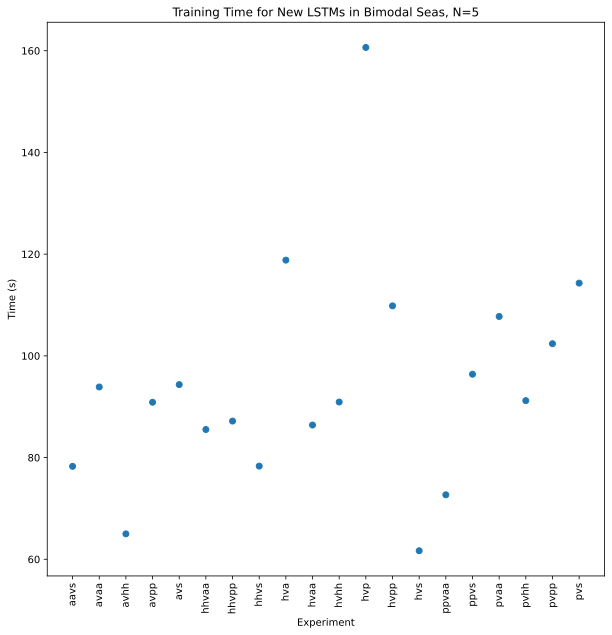

In [5]:
fig = plt.figure(figsize=(10,10))

plt.plot(exp_list,t,'o')
plt.xticks(rotation=90)
plt.ylabel('Time (s)')
plt.xlabel('Experiment')
plt.title('Training Time for New LSTMs in Bimodal Seas, N=5')
plt.show()

In [6]:
def generate_test_output(experiment='', N=5, save_folder=''):
    """Given an experiment generate and save output files"""
    
    # ID Experiment for tracking
    print("EXPERIMENT: ", experiment)

    exp_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\{experiment}'

    # Setup GPU Support
    print("Cuda available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # to avoid some rare errors.

    # Check if using CPU or GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set parameters
    args = UserInputArgs()
    data_info_args = DataInfoArgs()
    save_data_args = SaveDataArgs()

    # Update the args to 5 layers of 50 nodes
    args.num_layers = 5
    args.hidden_size = 50

    # Load the LSTM
    args.model_load_filename = exp_PATH + f'\\{experiment}_BiMod{args.num_layers}_{args.hidden_size}_{N}_LSTM'
    network, std_factors = load_lstm_info(args)
    network.to(device)

    # Create list of eligible files to train on
    test_files = [f for f in os.listdir(exp_PATH + '\\LAMP_files') if f.endswith('3.mot')]

    # test_files = files
    data_info_args.test_lamp = [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in test_files]
    data_info_args.test_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in test_files]

    # Setup Derived Args
    derived_args = DerivedArgs(args, data_info_args)
    derived_args.test_batch_size = int(derived_args.num_test_realizations * args.time_res / 9)
    # print("No of train realizations: ", derived_args.num_train_realizations)
    # print("No of val realizations: ", derived_args.num_val_realizations)
    print("No of test realizations: ", derived_args.num_test_realizations)
    # print("No of realizations: ", derived_args.num_realizations)
    # print("Train batch size: ", derived_args.train_batch_size)
    # print("Val batch size: ", derived_args.val_batch_size)
    print("Test batch size: ", derived_args.test_batch_size)

    # Load the training and validation data
    test_input, test_target, test_sc = load_and_standardize(data_info_args.test_sc, data_info_args.test_lamp, args, std_factors)

    # Reshape the data to take into account the time resolution
    test_input, test_target = reshape_for_time_resolution(test_input, test_target, args)

    # Create Dataset objects for each of our train/val/test sets
    test_dataset = S2LDataset(test_input, test_target)

    # Create testing dataloader
    test_loader = DataLoader(test_dataset, batch_size=derived_args.test_batch_size)

    # Display dataset information
    # print("\nReshaped the following data:")
    # print(f"train_input has shape	{train_input.shape}")
    # print(f"train_target has shape	{train_target.shape}")
    # print(f"val_input has shape 	{val_input.shape}")
    # print(f"val_target has shape 	{val_target.shape}")
    print(f"test_input has shape 	{test_input.shape}")
    print(f"test_target has shape 	{test_target.shape}")
    # realization_length = train_input.shape[1] * args.time_res

    # initialize our optimizer. We'll use Adam
    optimizer = torch.optim.Adam(network.parameters(), lr=args.lr)

    start_time = time.time()
    test_lstm_output = test(network,device,test_loader,args.val_fun_hyp,derived_args.num_test_realizations,args.time_res,True,)
    end_time = time.time()
    testTime = end_time - start_time
    print("Testing Time: ", testTime)
    # print("\ntrain output shape", train_lstm_output.shape)
    # print("val output shape  ", val_lstm_output.shape)
    print("test output shape ", test_lstm_output.shape)
    print("Time to produce output for ",derived_args.num_realizations," realizations:",(end_time - start_time),)

    # Reshape our input and targets to be same shape as output
    # train_input, train_target, train_lstm_output = reshape_full_series(train_input, train_target, train_lstm_output, args)
    # val_input, val_target, val_lstm_output = reshape_full_series(val_input, val_target, val_lstm_output, args)
    test_input, test_target, test_lstm_output = reshape_full_series(test_input, test_target, test_lstm_output, args)

    # Unstandardize
    # train_target, train_lstm_output = unstandardize_all_data(train_target, train_lstm_output, std_factors, args)
    # val_target, val_lstm_output = unstandardize_all_data(val_target, val_lstm_output, std_factors, args)
    test_target, test_lstm_output = unstandardize_all_data(test_target, test_lstm_output, std_factors, args)

    # # Print error report
    # print("\nLSTM Error Results:")
    # print_error_report(train_lstm_output,val_lstm_output,test_lstm_output,train_target,val_target,test_target,args,)
    
    # Save the output
    save_data_args.test = list(range(0,len(data_info_args.test_sc)))
    save_data_args.output_path = exp_PATH + f'\\{save_folder}\\'
    print("Saving output to ",save_data_args.output_path)
    save_lstm_test_results(test_lstm_output,save_data_args,data_info_args,args,std_factors,)
    print('')

In [7]:
PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\'
ignore = ['Cases_files', '.ipynb_checkpoints','SecAngleOnly_test','__pycache__']
for exp in os.listdir(PATH):
    if os.path.isdir(PATH + exp) and exp not in ignore:
        try:
            generate_test_output(exp,N=5,save_folder='output_files_BiMod5_50_5')
        except Exception as e:
            logging.error(traceback.format_exc())
            print('ERROR in ', exp)
            print('\n\n\n')
            continue

EXPERIMENT:  aavs
Cuda available: True
Loading LSTM Saved in:  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\Bimodal Test Sets\aavs\aavs_BiMod5_50_5_LSTM .pickle
No of test realizations:  216
Test batch size:  216
full series simple (input) shape  (216, 17990, 4)
full series lamp (target) shape  (216, 17990, 3)
test_input has shape 	(1944, 1998, 4)
test_target has shape 	(1944, 1998, 3)
Testing Time:  1.7735278606414795
test output shape  (1944, 1998, 3)
Time to produce output for  378  realizations: 1.7735278606414795
Saving output to  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\Bimodal Test Sets\aavs\output_files_BiMod5_50_5\

EXPERIMENT:  avaa
Cuda available: True
Loading LSTM Saved in:  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\Bimodal Test Sets\avaa\avaa_BiMod5_50_5_LSTM .pickle
No of test realizations:  288
T

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\2018205178.py", line 6, in <module>
    generate_test_output(exp,N=5,save_folder='output_files_BiMod5_50_5')
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\1874422866.py", line 50, in generate_test_output
    test_input, test_target, test_sc = load_and_standardize(data_info_args.test_sc, data_info_args.test_lamp, args, std_factors)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\load_and_standardize.py", line 48, in load_and_standardize
    lstm_inputs, target_outputs = load_fullseries(
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\load_and_standardize.py", line 38, in load_fullseries
    np.concatenate((simple_vbm_data, simple_motion_data, wave_data), axis=1)
  File "<__array_function__ internals>", line 180, in concatenate
ValueError: all the input array dimensions for the concatenati

ERROR in  hvp




EXPERIMENT:  hvpp
Cuda available: True
Loading LSTM Saved in:  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\Bimodal Test Sets\hvpp\hvpp_BiMod5_50_5_LSTM .pickle
No of test realizations:  81
Test batch size:  81
full series simple (input) shape  (81, 17990, 4)
full series lamp (target) shape  (81, 17990, 3)
test_input has shape 	(729, 1998, 4)
test_target has shape 	(729, 1998, 3)
Testing Time:  0.7041065692901611
test output shape  (729, 1998, 3)
Time to produce output for  243  realizations: 0.7041065692901611
Saving output to  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\Bimodal Test Sets\hvpp\output_files_BiMod5_50_5\

EXPERIMENT:  hvs
Cuda available: True
Loading LSTM Saved in:  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\Bimodal Test Sets\hvs\hvs_BiMod5_50_5_LSTM .pickle
No of test realizations

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\2018205178.py", line 6, in <module>
    generate_test_output(exp,N=5,save_folder='output_files_BiMod5_50_5')
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\1874422866.py", line 28, in generate_test_output
    network, std_factors = load_lstm_info(args)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\save_lstm.py", line 23, in load_lstm_info
    loaded_lstm = pickle.load(open(user_input_args.model_load_filename+".pickle", "rb"))
FileNotFoundError: [Errno 2] No such file or directory: 'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\pva\\pva_BiMod5_50_5_LSTM.pickle'




EXPERIMENT:  pva
Cuda available: True
Loading LSTM Saved in:  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\Bimodal Test Sets\pva\pva_BiMod5_50_5_LSTM .pickle
ERROR in  pva




EXPERIMENT:  pvaa
Cuda available: True
Loading LSTM Saved in:  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\Bimodal Test Sets\pvaa\pvaa_BiMod5_50_5_LSTM .pickle
No of test realizations:  216
Test batch size:  216
full series simple (input) shape  (216, 17990, 4)
full series lamp (target) shape  (216, 17990, 3)
test_input has shape 	(1944, 1998, 4)
test_target has shape 	(1944, 1998, 3)
Testing Time:  1.7855372428894043
test output shape  (1944, 1998, 3)
Time to produce output for  378  realizations: 1.7855372428894043
Saving output to  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\Bimodal Test Sets\pvaa\output_files_BiMod5_50_5\

EXPERIMENT:  pv

#### Transfer Learning Network

Copy medium network, train with same 5 files from bimodal network.

In [8]:
print("Cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # to avoid some rare errors.

# Check if using CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set parameters
args = UserInputArgs()
plot_args = PlottingArgs()
data_info_args = DataInfoArgs()
save_data_args = SaveDataArgs()

# args.training_mode = False

# Load original LSTM
args.model_load_filename = 'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\MED3_50\\MED3_50'
network, std_factors = load_lstm_info(args)
network.to(device)

Cuda available: True
Loading LSTM Saved in:  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\MED3_50\MED3_50 .pickle


LSTM(
  (lstm): LSTM(4, 50, num_layers=3, batch_first=True)
  (linear): Linear(in_features=50, out_features=3, bias=True)
)

In [9]:
def generateOutput(experiment, n=5, train_mode=True, save_folder='',):
    """Given an experiment and training sample size, generate and save output files"""
    print("EXPERIMENT: ", experiment)
    
    # Create list of eligible files to train on
    exp_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\{experiment}'
    files = [f for f in os.listdir(exp_PATH + '\\LAMP_files') if f.endswith('1.mot')]

    # Establish test files list (since we're testing on all in a folder)
    test_files = [f.replace('1.mot','3.mot') for f in files]
    # test_files = files
    data_info_args.test_lamp = [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in test_files]
    data_info_args.test_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in test_files]

    # Copy the MED LSTM
    model = copy.deepcopy(network)

    # Setup GPU Support
    print("Cuda available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # to avoid some rare errors.

    # Check if using CPU or GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    # randomly select N num_files
    train_files = np.random.choice(files, size=n, replace = False)
    # train_files = training_files[experiment]
    print("Training on: ", train_files)
    val_files = [f.replace('1.mot','2.mot') for f in train_files]
    # Shorten val_files to 20% of train_files
    val_files = np.random.choice(val_files, size=int(.2*len(val_files)), replace = False)

    # establish the lamp and sc training file paths
    data_info_args.train_lamp = [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in train_files]
    data_info_args.train_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in train_files]

    # establish the lamp and sc validation file paths
    data_info_args.val_lamp= [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in val_files]
    data_info_args.val_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in val_files]

    # Setup Derived Args
    derived_args = DerivedArgs(args, data_info_args)
    derived_args.test_batch_size = int(derived_args.num_test_realizations * args.time_res / 9)
    # print("No of train realizations: ", derived_args.num_train_realizations)
    # print("No of val realizations: ", derived_args.num_val_realizations)
    # print("No of test realizations: ", derived_args.num_test_realizations)
    # print("No of realizations: ", derived_args.num_realizations)
    # print("Train batch size: ", derived_args.train_batch_size)
    # print("Val batch size: ", derived_args.val_batch_size)
    # print("Test batch size: ", derived_args.test_batch_size)

    # Load the training and validation data
    train_input, train_target, train_sc = load_and_standardize(data_info_args.train_sc, data_info_args.train_lamp, args, std_factors)
    val_input, val_target, val_sc = load_and_standardize(data_info_args.val_sc, data_info_args.val_lamp, args, std_factors)
    test_input, test_target, test_sc = load_and_standardize(data_info_args.test_sc, data_info_args.test_lamp, args, std_factors)

    # Reshape the data to take into account the time resolution
    train_input, train_target = reshape_for_time_resolution(train_input, train_target, args)
    val_input, val_target = reshape_for_time_resolution(val_input, val_target, args)
    test_input, test_target = reshape_for_time_resolution(test_input, test_target, args)

    # Create Dataset objects for each of our train/val/test sets
    train_dataset = S2LDataset(train_input, train_target)
    val_dataset = S2LDataset(val_input, val_target)
    test_dataset = S2LDataset(test_input, test_target)

    # Create a PyTorch dataloader for each train/val set. Test set isn't needed until later
    train_loader = DataLoader(train_dataset, batch_size=derived_args.train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=derived_args.val_batch_size)

    # Create testing dataloader
    test_loader = DataLoader(test_dataset, batch_size=derived_args.test_batch_size)

    # Display dataset information
    # print("\nReshaped the following data:")
    # print(f"train_input has shape	{train_input.shape}")
    # print(f"train_target has shape	{train_target.shape}")
    # print(f"val_input has shape 	{val_input.shape}")
    # print(f"val_target has shape 	{val_target.shape}")
    # print(f"test_input has shape 	{test_input.shape}")
    # print(f"test_target has shape 	{test_target.shape}")
    realization_length = train_input.shape[1] * args.time_res

    # initialize our optimizer. We'll use Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    # Begin Training
    if train_mode == True:
        best_val_loss = float("inf")
        best_loss_counter = 0
        print("\n Beginning Training")
        start_time = time.time()
        for epoch in range(1, args.epochs + 1):
            train_loss = train(model, device, train_loader, optimizer, args.train_fun_hyp)
            val_loss = test(model, device, val_loader, args.val_fun_hyp)
            if val_loss < 0.95 * best_val_loss:
                best_val_loss = val_loss
                best_loss_counter = 0
                torch.save(model.state_dict(), "recently_trained_model.pt")
            else:
                best_loss_counter += 1
            if best_loss_counter > 30:
                break
            # print("Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tCounter: {:02d}".format(epoch, train_loss, val_loss, best_loss_counter))
        print("Training Done\n")
        end_time = time.time()
        trainTime = end_time - start_time
        print("Training Time: ", trainTime)
        model.load_state_dict(torch.load("recently_trained_model.pt"))  # restoring the best found network based on validation data

    start_time = time.time()
    train_lstm_output = test(model,device,train_loader,args.val_fun_hyp,derived_args.num_train_realizations,args.time_res,True,)
    val_lstm_output = test(model,device,val_loader,args.val_fun_hyp,derived_args.num_val_realizations,args.time_res,True,)
    test_lstm_output = test(model,device,test_loader,args.val_fun_hyp,derived_args.num_test_realizations,args.time_res,True,)
    end_time = time.time()
    testTime = end_time - start_time
    print("Testing Time: ", testTime)
    print("\ntrain output shape", train_lstm_output.shape)
    print("val output shape  ", val_lstm_output.shape)
    print("test output shape ", test_lstm_output.shape)
    print("Time to produce output for ",derived_args.num_realizations," realizations:",(end_time - start_time),)

    # Reshape our input and targets to be same shape as output
    train_input, train_target, train_lstm_output = reshape_full_series(train_input, train_target, train_lstm_output, args)
    val_input, val_target, val_lstm_output = reshape_full_series(val_input, val_target, val_lstm_output, args)
    test_input, test_target, test_lstm_output = reshape_full_series(test_input, test_target, test_lstm_output, args)

    # Unstandardize
    train_target, train_lstm_output = unstandardize_all_data(train_target, train_lstm_output, std_factors, args)
    val_target, val_lstm_output = unstandardize_all_data(val_target, val_lstm_output, std_factors, args)
    test_target, test_lstm_output = unstandardize_all_data(test_target, test_lstm_output, std_factors, args)

    # Print error report
    print("\nLSTM Error Results:")
    print_error_report(train_lstm_output,val_lstm_output,test_lstm_output,train_target,val_target,test_target,args,)
    
    # Save the output
    save_data_args.test = list(range(0,len(data_info_args.test_sc)))
    save_data_args.output_path = exp_PATH + f'\\{save_folder}\\'
    print("Saving output to ",save_data_args.output_path)
    save_lstm_results(train_lstm_output,val_lstm_output,test_lstm_output,save_data_args,data_info_args,args,std_factors,)
    print('')

In [10]:
PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\'
ignore = ['Cases_files', '.ipynb_checkpoints','SecAngleOnly_test','__pycache__']
for exp in os.listdir(PATH):
    if os.path.isdir(PATH + exp) and exp not in ignore:
        try:
            generateOutput(exp,n=5,train_mode=True,save_folder='output_files_MED5_50_5_rand',)
        except Exception as e:
            logging.error(traceback.format_exc())
            print('ERROR in ', exp)
            continue

EXPERIMENT:  aavs
Cuda available: True
Training on:  ['LAMP_h7.5_p15_a135_hh3_pp20_aa225_s0-0000001.mot'
 'LAMP_h7.5_p15_a135_hh3_pp20_aa240_s16-0000001.mot'
 'LAMP_h7.5_p15_a135_hh3_pp20_aa240_s10-0000001.mot'
 'LAMP_h7.5_p15_a135_hh3_pp20_aa90_s12-0000001.mot'
 'LAMP_h7.5_p15_a135_hh3_pp20_aa285_s6-0000001.mot']
full series simple (input) shape  (5, 17990, 4)
full series lamp (target) shape  (5, 17990, 3)
full series simple (input) shape  (1, 17990, 4)
full series lamp (target) shape  (1, 17990, 3)
full series simple (input) shape  (216, 17990, 4)
full series lamp (target) shape  (216, 17990, 3)

 Beginning Training
Training Done

Training Time:  42.89744520187378
Testing Time:  1.6934583187103271

train output shape (45, 1998, 3)
val output shape   (9, 1998, 3)
test output shape  (1944, 1998, 3)
Time to produce output for  222  realizations: 1.6934583187103271

LSTM Error Results:
--------------------------------------------
Training Data Errors:
MSE:                  tensor(39.8702

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\55266496.py", line 6, in <module>
    generateOutput(exp,n=5,train_mode=True,save_folder='output_files_MED5_50_5_rand',)
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\2194978089.py", line 58, in generateOutput
    test_input, test_target, test_sc = load_and_standardize(data_info_args.test_sc, data_info_args.test_lamp, args, std_factors)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\load_and_standardize.py", line 48, in load_and_standardize
    lstm_inputs, target_outputs = load_fullseries(
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\load_and_standardize.py", line 38, in load_fullseries
    np.concatenate((simple_vbm_data, simple_motion_data, wave_data), axis=1)
  File "<__array_function__ internals>", line 180, in concatenate
ValueError: all the input array dimensions for the conca

ERROR in  hvp
EXPERIMENT:  hvpp
Cuda available: True
Training on:  ['LAMP_h5.5_p15_a135_hh3_pp21_aa270_s8-0000001.mot'
 'LAMP_h7_p15_a135_hh3_pp23_aa270_s8-0000001.mot'
 'LAMP_h9.5_p15_a135_hh3_pp20_aa270_s8-0000001.mot'
 'LAMP_h5.5_p15_a135_hh3_pp22_aa270_s8-0000001.mot'
 'LAMP_h6.5_p15_a135_hh3_pp17_aa270_s8-0000001.mot']
full series simple (input) shape  (5, 17990, 4)
full series lamp (target) shape  (5, 17990, 3)
full series simple (input) shape  (1, 17990, 4)
full series lamp (target) shape  (1, 17990, 3)
full series simple (input) shape  (81, 17990, 4)
full series lamp (target) shape  (81, 17990, 3)

 Beginning Training
Training Done

Training Time:  57.33538031578064
Testing Time:  0.8317165374755859

train output shape (45, 1998, 3)
val output shape   (9, 1998, 3)
test output shape  (729, 1998, 3)
Time to produce output for  87  realizations: 0.8317165374755859

LSTM Error Results:
--------------------------------------------
Training Data Errors:
MSE:                  tensor(6

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\55266496.py", line 6, in <module>
    generateOutput(exp,n=5,train_mode=True,save_folder='output_files_MED5_50_5_rand',)
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\2194978089.py", line 29, in generateOutput
    train_files = np.random.choice(files, size=n, replace = False)
  File "mtrand.pyx", line 915, in numpy.random.mtrand.RandomState.choice
ValueError: 'a' cannot be empty unless no samples are taken




EXPERIMENT:  pva
Cuda available: True
ERROR in  pva
EXPERIMENT:  pvaa
Cuda available: True
Training on:  ['LAMP_h7.5_p14_a135_hh3_pp20_aa285_s8-0000001.mot'
 'LAMP_h7.5_p19_a135_hh3_pp20_aa210_s8-0000001.mot'
 'LAMP_h7.5_p12_a135_hh3_pp20_aa255_s8-0000001.mot'
 'LAMP_h7.5_p19_a135_hh3_pp20_aa180_s8-0000001.mot'
 'LAMP_h7.5_p18_a135_hh3_pp20_aa30_s8-0000001.mot']
full series simple (input) shape  (5, 17990, 4)
full series lamp (target) shape  (5, 17990, 3)
full series simple (input) shape  (1, 17990, 4)
full series lamp (target) shape  (1, 17990, 3)
full series simple (input) shape  (216, 17990, 4)
full series lamp (target) shape  (216, 17990, 3)

 Beginning Training
Training Done

Training Time:  39.982433795928955
Testing Time:  1.6709392070770264

train output shape (45, 1998, 3)
val output shape   (9, 1998, 3)
test output shape  (1944, 1998, 3)
Time to produce output for  222  realizations: 1.6709392070770264

LSTM Error Results:
--------------------------------------------
Trainin

In [11]:
# def LSTMvLAMP_df(experiment="",LSTM_files='', realization=''):
    
#     from pathlib import Path
#     import pandas as pd

#     """Makes a dataframe comparing LSTM and LAMP outputs
#         experiment = folder name of the experiment"""

#     # Establish paths
#     exp_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\{experiment}\\'

#     # network options
#     # nwOptions = ('original', 'new')
    
#     # No experiment or network given
#     if experiment == "" or LSTM_files == '':
#         return "INVALID EXPERIMENT OR NETWORK"

#     # Parse out the variables observed
#     v1 = experiment.partition("v")[0]  # Pulls first variable by taking string before "_", spliting at the "v"
#     v2 = experiment.partition("v")[2]  # 2nd variable

#     # LAMP path
#     LAMP_path = exp_PATH + "\\LAMP_files\\"

#     # LSTM data
#     exp_PATH += LSTM_files + '\\'

#     # Set experiment path
#     # if network.lower() == "original":
#     #     exp_PATH += "\\output_files_MED\\"
#     # elif network.lower() == "new":
#     #     exp_PATH += "\\output_files_MED2_30_50\\"

#     # Make the dataframe for LSTM
#     df_LSTM = pd.DataFrame(
#         columns=[v1, v2, "Zcg", "Roll", "Pitch"]
#     )  # Create cols for the altered variables in experiement and heave, roll, pitch

#     # step through every LSTM file in the experiement to get the SSA, and add to dataframe
#     for path in Path(exp_PATH).glob(f"*{realization}.txt"):
#         # Get the SSA's
#         SSA = get_LSTM_SSA(path)
#         # Get the variable combo for the file
#         trial = path.name.lstrip("lstm_output_for_SC_")
#         idx = trial.partition(v1)[2]
#         t1 = idx.partition("_")[0]
#         if v2 == "s":
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("-")[0]
#         else:
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("_")[0]

#         SSA[v1] = float(t1)
#         SSA[v2] = float(t2)

#         df_LSTM.loc[len(df_LSTM)] = SSA

#     df_LSTM = df_LSTM.sort_values(by=[v1, v2])

#     # Make the dataframe for LAMP
#     df_LAMP = pd.DataFrame(columns=[v1, v2, "Zcg", "Roll", "Pitch"])

#     # step through every LAMP file in the experiement to get the SSA, and add to dataframe
#     for path in Path(LAMP_path).glob(f"*{realization}.mot"):
#         # Get the SSA's
#         SSA = get_LAMP_SSA(path)
#         # Get the variable combo for the file
#         trial = path.name.lstrip("LAMP_")
#         idx = trial.partition(v1)[2]
#         t1 = idx.partition("_")[0]
#         if v2 == "s":
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("-")[0]
#         else:
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("_")[0]

#         SSA[v1] = float(t1)
#         SSA[v2] = float(t2)

#         df_LAMP.loc[len(df_LAMP)] = SSA

#     df_LAMP = df_LAMP.sort_values(by=[v1, v2])

#     # Establish new, final DF for heatmap
#     df_final = pd.DataFrame(columns=[v1, v2, "Zcg Error", "Roll Error", "Pitch Error"])
#     df_final[v1] = df_LSTM[v1]
#     df_final[v2] = df_LSTM[v2]

#     # find the absolute difference between each in the series
#     df_final["Zcg Error"] = np.abs(df_LSTM["Zcg"] - df_LAMP["Zcg"])
#     df_final["Roll Error"] = np.abs(df_LSTM["Roll"] - df_LAMP["Roll"])
#     df_final["Pitch Error"] = np.abs(df_LSTM["Pitch"] - df_LAMP["Pitch"])

#     return df_final, v1, v2

In [12]:
# def makeHeatmap(top_network,bottom_network, experiment, parameter, realization, save_file):
#     import seaborn as sns
#     """
#     Creates a heatmap of SSA error between unimodal LSTM and same LSTM trained with bimodal seas. Given a df of the form:
#     v1      v2    Zcg Error       Roll Error    Pitch Error
#     experiment = case file
#     network = network trained on
#     parameter = parameter we want to see
#     """

#     # Renaming Based on Experiment ID
#     EXP_ID = {'aa': 'Secondary Heading', 'a': 'Primary Heading', 'hh': 'Secondary Height', 'h': 'Primary Height', 'pp': 'Secondary Period', 'p': 'Primary Period', 's': 'Ship Speed'}
#     EXP_ID_units = {'aa': r'$Secondary Heading (^{\circ})$', 'a': r'$Primary Heading (^{\circ})$', 'hh': 'Secondary Height (m)', 'h': 'Primary Height (m)', 'pp': 'Secondary Period (sec)', 'p': 'Primary Period (sec)', 's': 'Ship Speed (knots)'}
#     plot_ID = experiment.split('v')

#     # Set save path for the figure
#     SAVE_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Transfer Learning Figures\\{save_file}'

#     # Set units for color bar
#     if parameter == "Zcg Error":
#         units = "meters"
#     else:
#         units = r"$^{\circ}$"

#     # Set the fig and ax
#     fig, (axo, axn, axd) = plt.subplots(3, figsize=(16, 16), sharey=True)
#     # cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
#     cbar_ax = fig.add_axes([0.91, 0.425, 0.03, 0.4])
#     rbar_ax = fig.add_axes([0.91, 0.125, 0.03, 0.2])
#     fig.suptitle(f"{EXP_ID[plot_ID[0]]} vs {EXP_ID[plot_ID[1]]} Absolute SSA {parameter}", fontsize=18)
#     fig.supxlabel(f'{EXP_ID_units[plot_ID[0]]}')
#     fig.supylabel(f'{EXP_ID_units[plot_ID[1]]}')
#     colormap= sns.diverging_palette(0,145,sep=15,as_cmap=True)
#     cbar_ax.set_ylabel(units)

#     # get the Original dataset
#     dfo, v1, v2 = LSTMvLAMP_df(experiment, 'output_files_'+top_network, realization)
#     resulto = dfo.pivot(index=v2, columns=v1, values=parameter)

#     # Set colorbar max value
#     vmax = resulto.max().max()

#     # get the new dataset
#     dfn, v1, v2 = LSTMvLAMP_df(experiment, 'output_files_'+bottom_network, realization)
#     resultn = dfn.pivot(index=v2, columns=v1, values=parameter)

#     # Set colorbar max value to that of new if it's more than med
#     if resultn.max().max() > vmax:
#         vmax = resultn.max().max()

#     # Plot original dataset
#     g1 = sns.heatmap(
#         resulto,cmap="Blues",ax=axo, cbar=True,vmax=vmax,cbar_ax=cbar_ax, # annot = True, fmt = ".2f"
#     )
#     g1.invert_yaxis()
#     if 'BiMod' in top_network:
#         g1.set_title("Bimodal Training, N=" + top_network[-1])
#     else:
#         g1.set_title("Transfer Learning, N=" + top_network[-1])
#     g1.set_xlabel('')
#     g1.set_ylabel('')

#     # get the new dataset
#     g2 = sns.heatmap(
#         resultn, cmap="Blues", ax=axn, cbar_kws={"label": units}, cbar=True, vmax=vmax, cbar_ax=cbar_ax, # annot = True, fmt = ".2f"
#     )
#     g2.invert_yaxis()
#     if 'BiMod' in bottom_network:
#         g2.set_title("Bimodal Training, N=" + bottom_network[-1])
#     else:
#         g2.set_title("Transfer Learning, N=" + bottom_network[-1])
#     g2.set_xlabel('')
#     g2.set_ylabel('')

#     # Plot a heatmap comparing the difference between the two.  Bigger is better b/c delta_orig - delta_new means new performed much better
#     dfc = dfn.copy()
#     cols =  dfo.columns.difference([v1,v2])
#     dfc[cols] = dfo[cols] - dfn[cols]
#     resultc = dfc.pivot(index=v2, columns=v1, values=parameter)

#     # set colorbar max and min values
#     vmax = resultc.max().max()
#     vmin = resultc.min().min()

#     g3 = sns.heatmap(
#         resultc, cmap=colormap, ax=axd, cbar_kws={'label': units, 'ticks':[vmin,0,vmax], 'format': '%.2f'}, cbar=True, center=0, cbar_ax=rbar_ax, # annot = True, fmt = ".2f"
#     )
#     g3.invert_yaxis()
#     g3.set_title("Delta")
#     g3.set_xlabel('')
#     g3.set_ylabel('')

#     # Save the figure
#     plt.savefig(f"{SAVE_PATH}\\{experiment}_{save_file}_{parameter}_{realization}.png")


### Testing HeatMaps

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\1395063554.py", line 6, in <module>
    makeHeatmap(top_network='BiMod5_50_5',bottom_network='MED5_50_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod5_Bigger')
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\data_functions.py", line 203, in makeHeatmap
    resulto = dfo.pivot(index=v2, columns=v1, values=parameter)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\frame.py", line 7885, in pivot
    return pivot(self, index=index, columns=columns, values=values)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\reshape\pivot.py", line 520, in pivot
    return indexed.unstack(columns_listlike)
  File "h:\OneDrive - Massachusetts Institute of Technology\Th

ERROR in  hvp


ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_13460\1395063554.py", line 6, in <module>
    makeHeatmap(top_network='BiMod5_50_5',bottom_network='MED5_50_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod5_Bigger')
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\data_functions.py", line 203, in makeHeatmap
    resulto = dfo.pivot(index=v2, columns=v1, values=parameter)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\frame.py", line 7885, in pivot
    return pivot(self, index=index, columns=columns, values=values)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\reshape\pivot.py", line 520, in pivot
    return indexed.unstack(columns_listlike)
  File "h:\OneDrive - Massachusetts Institute of Technology\Th

ERROR in  pva


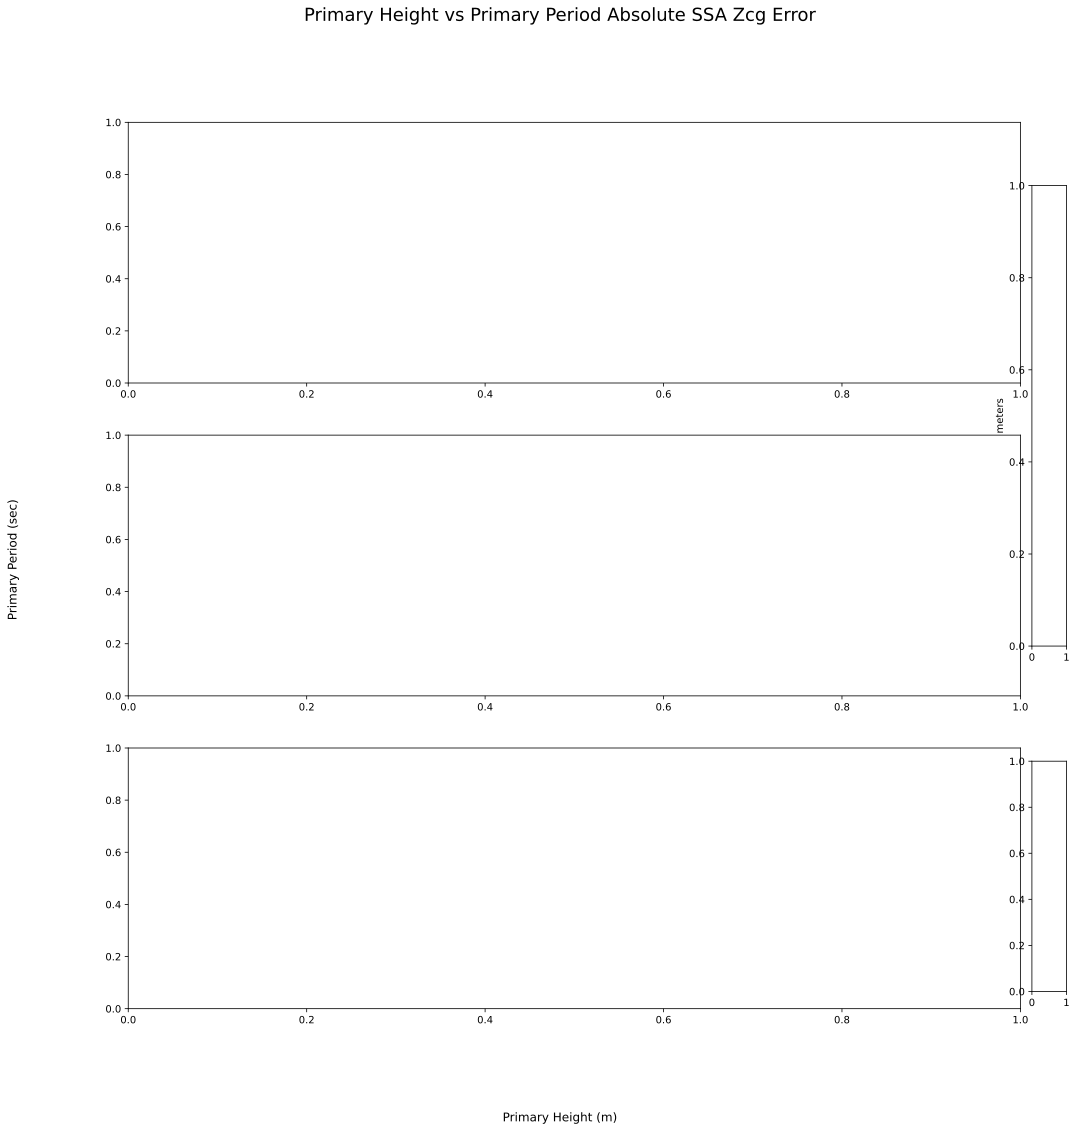

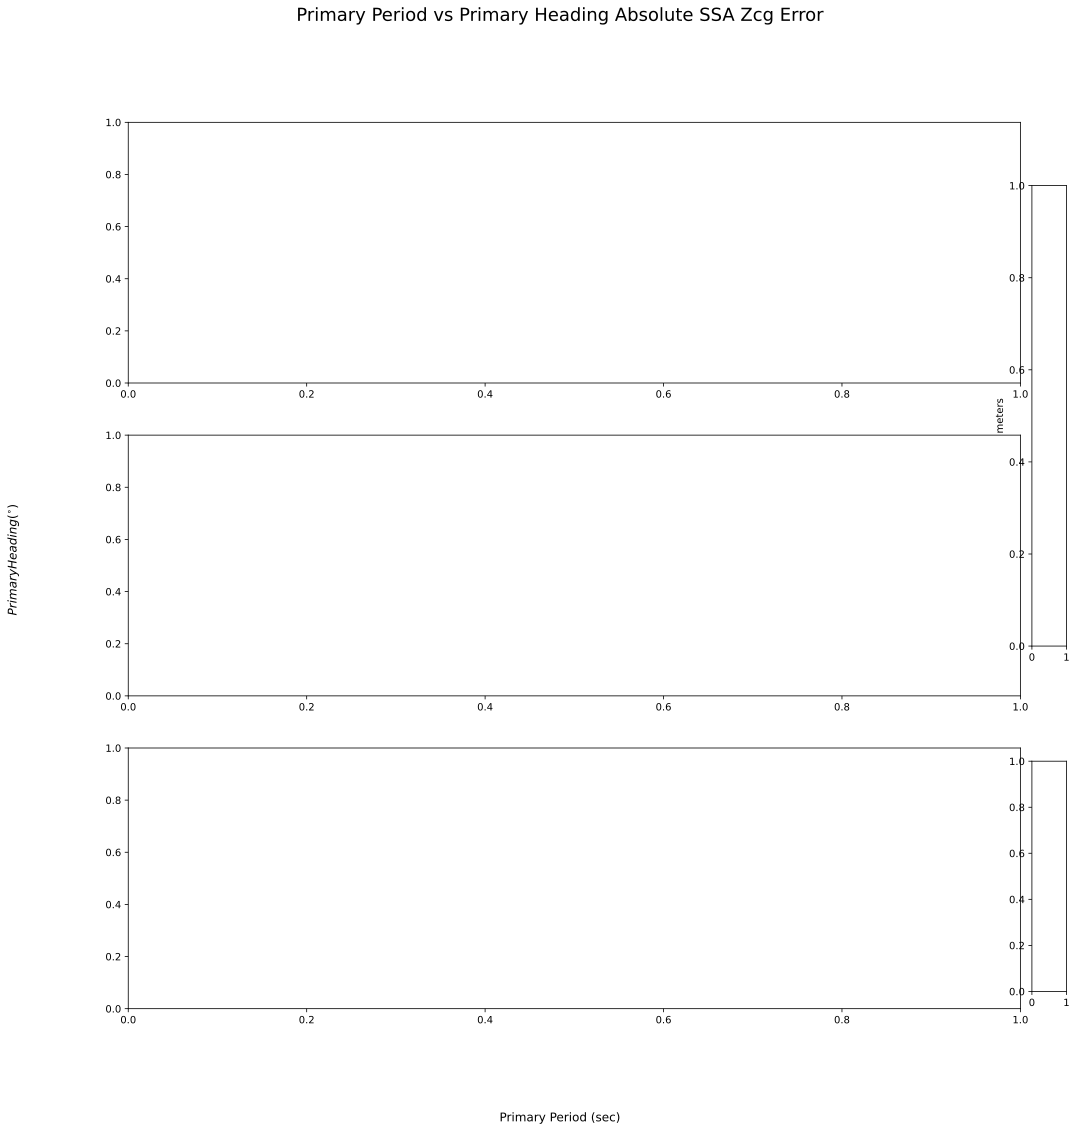

In [13]:
PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\'
ignore = ['Cases_files', '.ipynb_checkpoints','SecAngleOnly_test','__pycache__']
for exp in os.listdir(PATH):
    if os.path.isdir(PATH + exp) and exp not in ignore:
        try:
            makeHeatmap(top_network='BiMod5_50_5',bottom_network='MED5_50_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod5_Bigger')
            plt.close()
            makeHeatmap(top_network='BiMod5_50_5',bottom_network='MED5_50_5_rand',experiment=exp, parameter="Roll Error", realization='3', save_file='TL5_vs_BiMod5_Bigger')
            plt.close()
            makeHeatmap(top_network='BiMod5_50_5',bottom_network='MED5_50_5_rand',experiment=exp, parameter="Pitch Error", realization='3', save_file='TL5_vs_BiMod5_Bigger')
            plt.close()
        except Exception as e:
            logging.error(traceback.format_exc())
            print('ERROR in ', exp)
            continue

try:
    makeHeatmap(top_network='BiMod2_30_5',bottom_network='MED2_30_5',experiment='aavs', parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod5')
    # makeHeatmap('aavs', "Roll Error", '3')
    # makeHeatmap('aavs', "Pitch Error", '3')
except Exception as e:
    logging.error(traceback.format_exc())